In [1]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
import anndata as ad

import numpy as np
import pandas as pd
# import itables

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc_context
import patchworklib as pw
import seaborn.objects as so
import hvplot
import hvplot.pandas

from typing import List, Dict

from IPython.display import display
from os import walk, path, mkdir, listdir, cpu_count
import session_info
import logging
from utils.preprocessing_funcs import *

logging.basicConfig(level=logging.ERROR)
sc.set_figure_params(dpi = 100, dpi_save = 300, format= "png")
sc.settings.n_jobs = int(cpu_count() * 0.8)


<Figure size 96x96 with 0 Axes>

In [2]:
# -.-|m { input: false, output: false, input_fold: show}
"in the following cell, override the default pipeline parameters if needed"

#QC Params
CONCAT_SAMPLES: bool = True         # Concatenate all samples in one object, default: true
NMADS: int = 5                      # Number of median absolute deviations for read and gene counts.    
NMADS_MITO: int = 3                 # Number of median absolute deviations for mitochondrial genes percentage.
CORRECT_AMBIENT_RNA: bool = False   # Correct ambient RNA, uses DecontX, Currently causes multiple erros.
FILTER_DOUBLETS: bool = False       # Filter doublets using Scrublet
CELL_CYCLE_SCORE: bool = True       # Calculate cell cycle scores, based on scanpy implementation.
REGRESS: bool = False               # Regress out unwanted variables. Not recommended.
VARS_TO_REGRESS: List[str] = []     # list of regress (pct_counts_mt, pct_counts_ribo).


############################################################
####################     QC Dict      ######################
############################################################

"""
Can either be a flat-dict for global threshold or a dict of dicts for each sample 
Entries in the form of col_name: [low, high] Ex: 'pct_counts_mt':[0, 20] which will be used as (low, high) pair.
Also entries can be a single number Ex: 'pct_counts_mt': 3 which be used as number of MADS as follows media -+ nmad * MAD. 
"""

# by default, filtering on read counts, number of features, and mitochondrial content
qc_dict: Dict[str, List] | Dict[str, List] = {
    "pct_counts_mt": 3,
    "n_genes_by_counts": 5,
    "total_counts": 5
}

# MODIFY_ME, Specifiy only after running diagnotics on the samples
# global config
# qc_dict: Dict[str, List] | Dict[str, List] = {
#     "pct_counts_mt": [0, 10],
#     "pct_counts_rb": [0, 10],
#     "n_genes_by_counts": [1500, 9000],
#     "total_counts": [3_000, 40_000]
# }


# # per-sample config
# qc_dict: Dict[str, List] | Dict[str, List] = {
#     "sample1": {
#         "pct_counts_mt": [0, 10],
#         "pct_counts_rb": [0, 10],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample2": {
#         "pct_counts_rb": [0, 10],
#         "n_genes_by_counts": [1500, 9000],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample3": {
#         "pct_counts_mt": [0, 10],
#         "n_genes_by_counts": [1500, 9000],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample4": {
#         "pct_counts_mt": [0, 10],
#         "pct_counts_rb": [0, 10],
#         "n_genes_by_counts": [1500, 9000],
#     }
# }

In [3]:
## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [4]:
#Directories 
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
DIR_samples = config["basic"]["DIR_SAMPLES"]

#Basic information
TECHNOLOGY: str = config["basic"]["TECHNOLOGY"]
ORGANISM: str = config["basic"]["ORGANISM"]
AUTODISCOVER: bool = config["basic"]["auto_find"]
samples: Dict[str, str] = config["basic"]["samples"]

sample_components = inputs[TECHNOLOGY]["files"]
black_list = inputs[TECHNOLOGY]["black_list"]
read_function = inputs[TECHNOLOGY]["function"]
raw_name = inputs[TECHNOLOGY]["raw_name"]

In [5]:
# Diagnosic pipeline
## Reading files

if AUTODISCOVER and len(samples) == 0:
    files = walk(DIR_samples)
    for root, dir, files in files:
        if len(set(sample_components).difference(set(files))) == 0 and path.basename(root) != raw_name:
            samples[get_sample_name(root, black_list, 5)] = root
else:
    samples = config["basic"]["samples"]
    if len(samples) > 0:
        pass
    else:
        raise RuntimeError("No samples paths were provided, provide sample paths as a dictionary in 'config.toml'")

# Samples (auto-discovered or manually added)

In [6]:
# pd.DataFrame(samples,  index = ["sample path"]).T
(pd.DataFrame(samples,  index = ["sample path"]).T)

sample path
sample1  ../test/sample1/outs/filtered_feature_bc_matrix
sample3  ../test/sample3/outs/filtered_feature_bc_matrix
sample4  ../test/sample4/outs/filtered_feature_bc_matrix
sample2  ../test/sample2/outs/filtered_feature_bc_matrix

In [7]:
adatas = {}
raw_h5 = {}
for sample_id, filename in samples.items():
    sample_adata = read_function(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata


if TECHNOLOGY == "10x" and CORRECT_AMBIENT_RNA:
    for sample_id, filename in samples.items():
        files = listdir(path.dirname(filename))
        raw_file = [file for file in files if "raw_feature_bc_matrix" in file and ".h5" in file]
        if len(raw_file) == 1:
            adata_raw = sc.read_10x_h5(path.join(path.dirname(filename), raw_file[0]))
        else:
            raise ValueError("No/Multiple raw files meeting condition were found")

        adata_raw.var_names_make_unique()
        raw_h5[sample_id] = adata_raw


if CONCAT_SAMPLES:
    adata = ad.concat(adatas, label="sample", join="outer", merge="same")
    adata.obs_names_make_unique()
    del samples

if CONCAT_SAMPLES and TECHNOLOGY == "10x" and CORRECT_AMBIENT_RNA:
    adata_raw = ad.concat(raw_h5, label="sample", join="outer", merge="same")
    adata_raw.obs_names_make_unique()
    del raw_h5


In [8]:
## Adding quality metrics

"""**TODO:**
- [ ] Make the Oulier function parameterized on sample
"""

mt_features = qc_features_fac[ORGANISM]["mito"]
rb_features = qc_features_fac[ORGANISM]["ribo"]
hb_features = qc_features_fac[ORGANISM]["hb"]


# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith(tuple(mt_features))
# ribosomal genes
adata.var["rb"] = adata.var_names.str.startswith(tuple(rb_features))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(tuple(hb_features)[0]) #Only regex is accepted

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "rb", "hb"], percent_top=[20],  inplace=True, log1p=True
)


In [9]:
#TODO: Add additional Critera for filtering based on Absolute thresholds, can it be per sample?
if len(qc_dict) > 0 and all(map(lambda x: isinstance(x, list), qc_dict.values())):
        reduce_outliers(adata, qc_dict)
elif len(qc_dict) > 0 and all(map(lambda x: isinstance(x, dict), qc_dict.values())):
        reduce_outliers(adata, qc_dict, subset= True)
else:
    adata.obs["total_counts_outlier"] = is_outlier(adata, "total_counts", NMADS)
    adata.obs["n_genes_by_counts_outlier"] = is_outlier(adata, "n_genes_by_counts", NMADS)
    adata.obs["pct_counts_mt_outlier"] = is_outlier(adata, "pct_counts_mt", NMADS_MITO)
    adata.obs["outlier"] = adata.obs["total_counts_outlier"] | adata.obs["n_genes_by_counts_outlier"] | adata.obs["pct_counts_mt_outlier"]

In [10]:
## Ambient RNA correction
## TODO: Check if the Ambient RNA can be improved by using Batch information?

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":

    from os import system, remove, path
    import tempfile
    import urllib.request

    with tempfile.TemporaryDirectory(dir=".") as tmpdirname:

        # Workaround failure to install GenomeInfoDbData using pixi
        dn_path = path.join(tmpdirname, "GenomeInfoDbData_1.2.11.tar.gz")
        dn_url = "https://bioconductor.org/packages/3.18/data/annotation/src/contrib/GenomeInfoDbData_1.2.11.tar.gz"
        urllib.request.urlretrieve(dn_url, filename=dn_path)
        system(f"R CMD INSTALL {dn_path}")

        # Define paths for temporary files
        sce_path = path.join(tmpdirname, "sce.h5ad")
        raw_path = path.join(tmpdirname, "raw.h5ad")
        decontx_path = path.join(tmpdirname, "decontX.h5ad")
        
        # Save adata and adata_raw to the temporary directory
        adata.write_h5ad(sce_path)
        adata_raw.write_h5ad(raw_path)
        
        # Execute R scripts with temporary file paths
        system(f"Rscript ./utils/deconx.R -s {sce_path} -r {raw_path} -o {decontx_path}")

        # Read the result back from the temporary directory
        adata = sc.read_h5ad(decontx_path)

In [11]:
## Doublet Detection

#TODO: Check real-life performance
#TODO: Check Interop with R to convert object to R & vice-versa 
if FILTER_DOUBLETS and TECHNOLOGY == "10x":
    sc.pp.scrublet(adata, batch_key="sample")

In [12]:
## Cell cycle Scoring
# **Not reliable, do via interop later**

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)


if CELL_CYCLE_SCORE:
    if ORGANISM in ["human", "mouse"]:

        s_genes = [x.strip() for x in open('../resources/s_genes.txt')]
        g2m_genes = [x.strip() for x in open('../resources/s_genes.txt')]


        if ORGANISM == "mouse":
            s_genes = human2mouse(s_genes)
            g2m_genes = human2mouse(g2m_genes)


        # Cell cycle scoring is not reliable and not similair to Seurat
        sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    else:
        logging.error('Organism must be either human or mouse.')

# Quality Plots

In [13]:
# sc.set_figure_params(dpi=300, color_map="viridis_r")
# sc.settings.verbosity = 0

## Basic QC plots & metrics

In [14]:

if len(get_keys(qc_dict)) == 0:
    keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_rb"]
else: 
    keys = get_keys(qc_dict)

prior_keys = keys

if FILTER_DOUBLETS:
    keys = keys + ["doublet_score"]

if CELL_CYCLE_SCORE:
    keys = keys + ["S_score", "G2M_score"]

# Remove Duplicates
keys = list(set(keys))

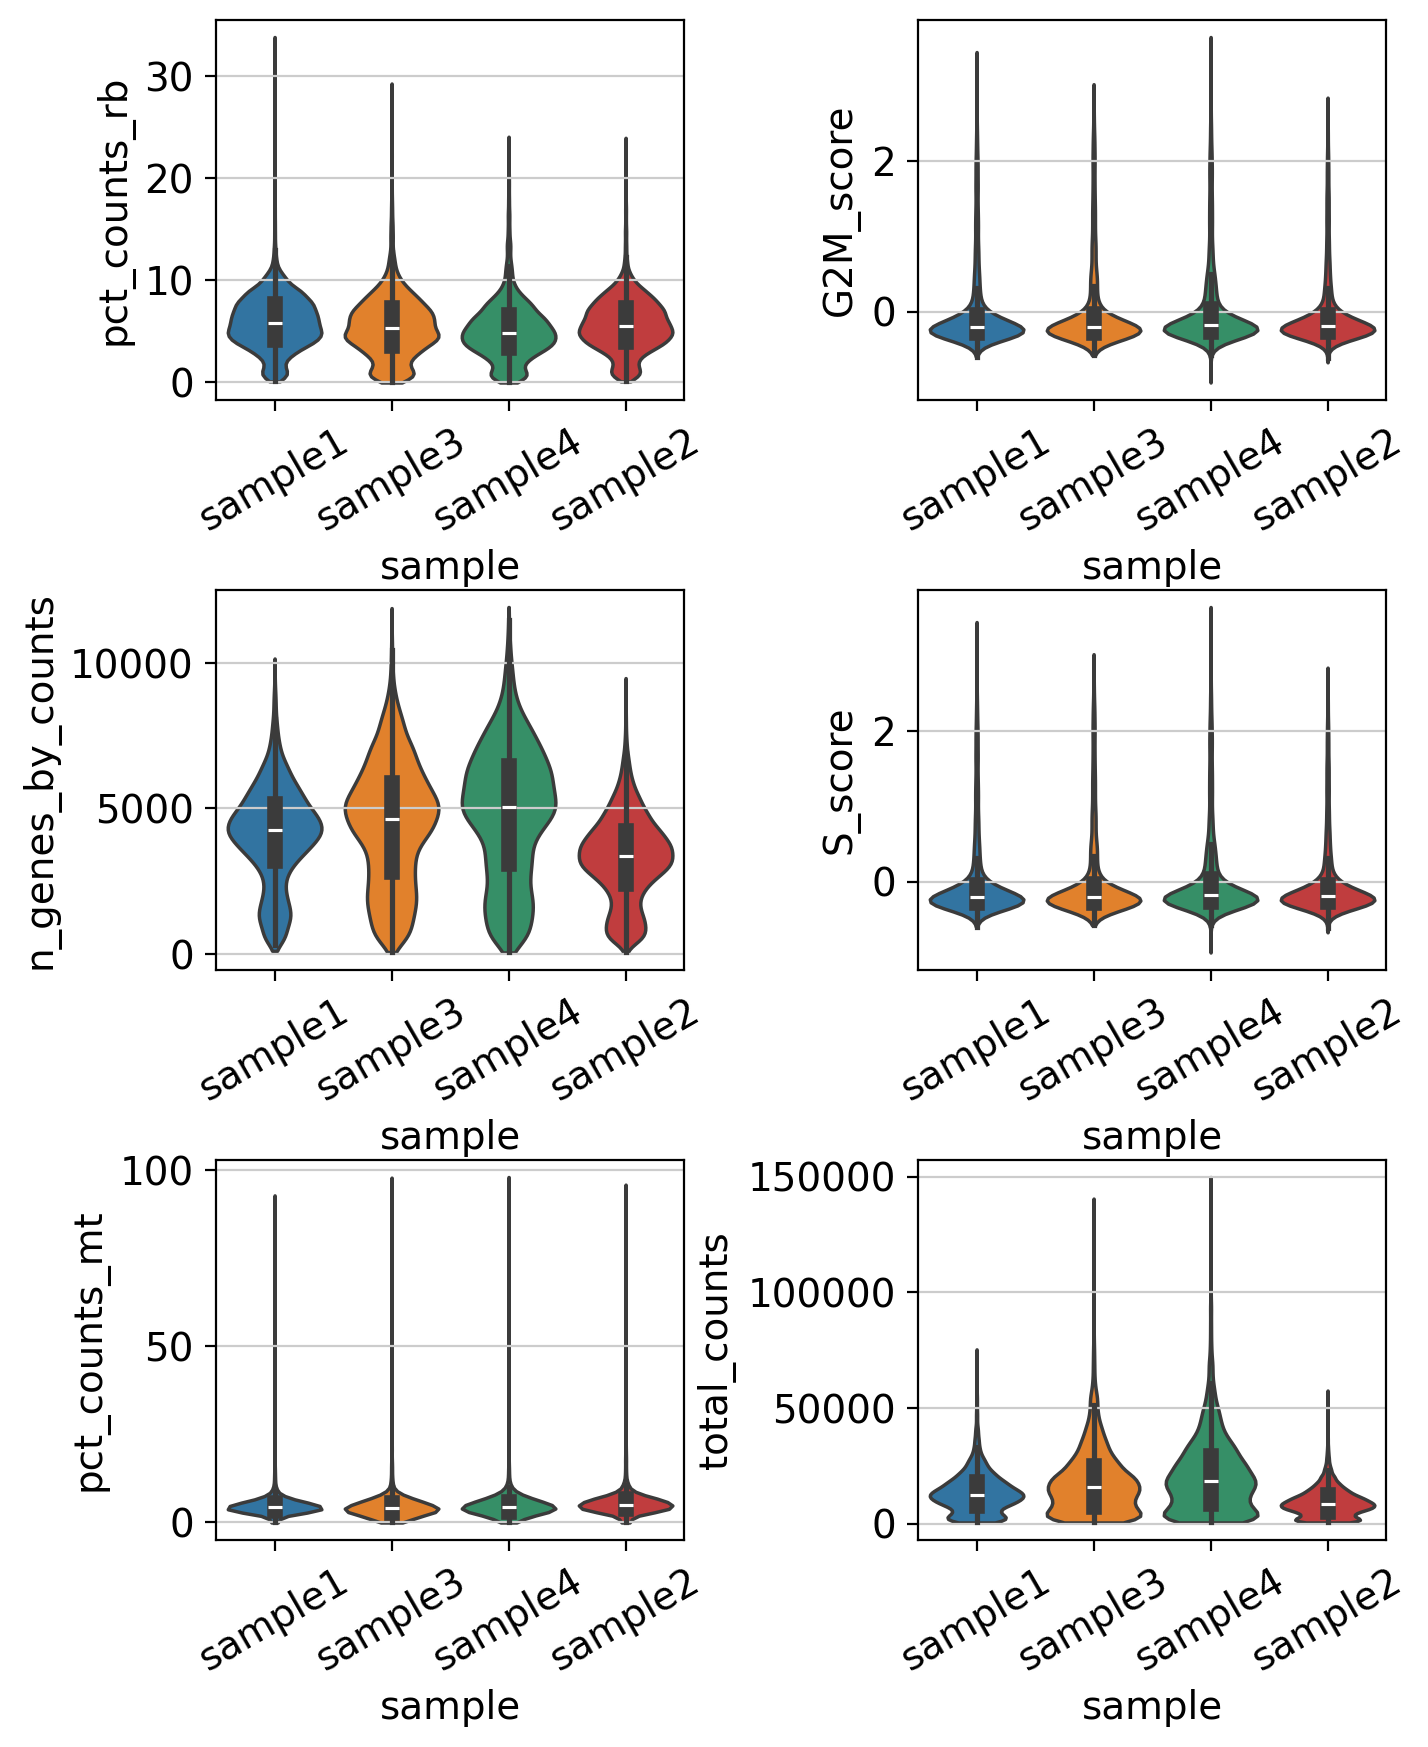

<Figure size 400x400 with 0 Axes>

In [15]:

ncols = 2
nrows = len(keys) // ncols + len(keys) % ncols

figsize = 3
wspace = 0.5
hspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize + hspace * (nrows - 1) ),
)
plt.subplots_adjust(wspace=wspace, hspace=hspace)

axs = axs.flatten()

# Prevent the subplots from showing 
plt.close(fig)


for i, key in enumerate(keys):
    sc.pl.violin(adata, keys=[key], groupby="sample", stripplot=False, inner="box", ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=30)

plt.tight_layout()
display(fig)


### Table of basic QC metrics

In [16]:
df1 = adata.obs.groupby("sample")[keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
(pd.concat([df1, df2], axis =1))

pct_counts_rb        G2M_score        n_genes_by_counts          \
                 mean median      mean median              mean  median   
sample                                                                    
sample1         5.922  5.839    -0.009 -0.200          4078.270  4238.0   
sample3         5.475  5.318     0.012 -0.203          4441.597  4633.5   
sample4         5.128  4.855     0.035 -0.180          4816.131  5045.0   
sample2         5.658  5.561    -0.027 -0.191          3283.994  3361.0   

        S_score        pct_counts_mt         total_counts          sample  
           mean median          mean median          mean   median   size  
sample                                                                     
sample1  -0.009 -0.200         4.811  4.394  13508.561523  12549.0   9197  
sample3   0.012 -0.203         4.610  4.024  18033.693359  15636.5   8222  
sample4   0.035 -0.180         5.018  4.314  20888.236328  18396.0   7365  
sample2  -0.027 -0.191         5.623  5.048   9307.657227   8527.0  10290

## Histograms

In [17]:
from operator import add

hvplot.extension("bokeh")
ls = []
df = adata.obs[keys]
for key in df.columns:
    fig = df[key].hvplot(kind = "hist", bins = 300, color = "#A3D5FF", width = 400, line_color = "#A3D5FF", bgcolor = "white").opts(axiswise=True)
    ls.append(fig)

layout = reduce(add, ls)
layout.cols(2)

:Layout
   .Histogram.I   :Histogram   [pct_counts_rb]   (Count)
   .Histogram.II  :Histogram   [G2M_score]   (Count)
   .Histogram.III :Histogram   [n_genes_by_counts]   (Count)
   .Histogram.IV  :Histogram   [S_score]   (Count)
   .Histogram.V   :Histogram   [pct_counts_mt]   (Count)
   .Histogram.VI  :Histogram   [total_counts]   (Count)

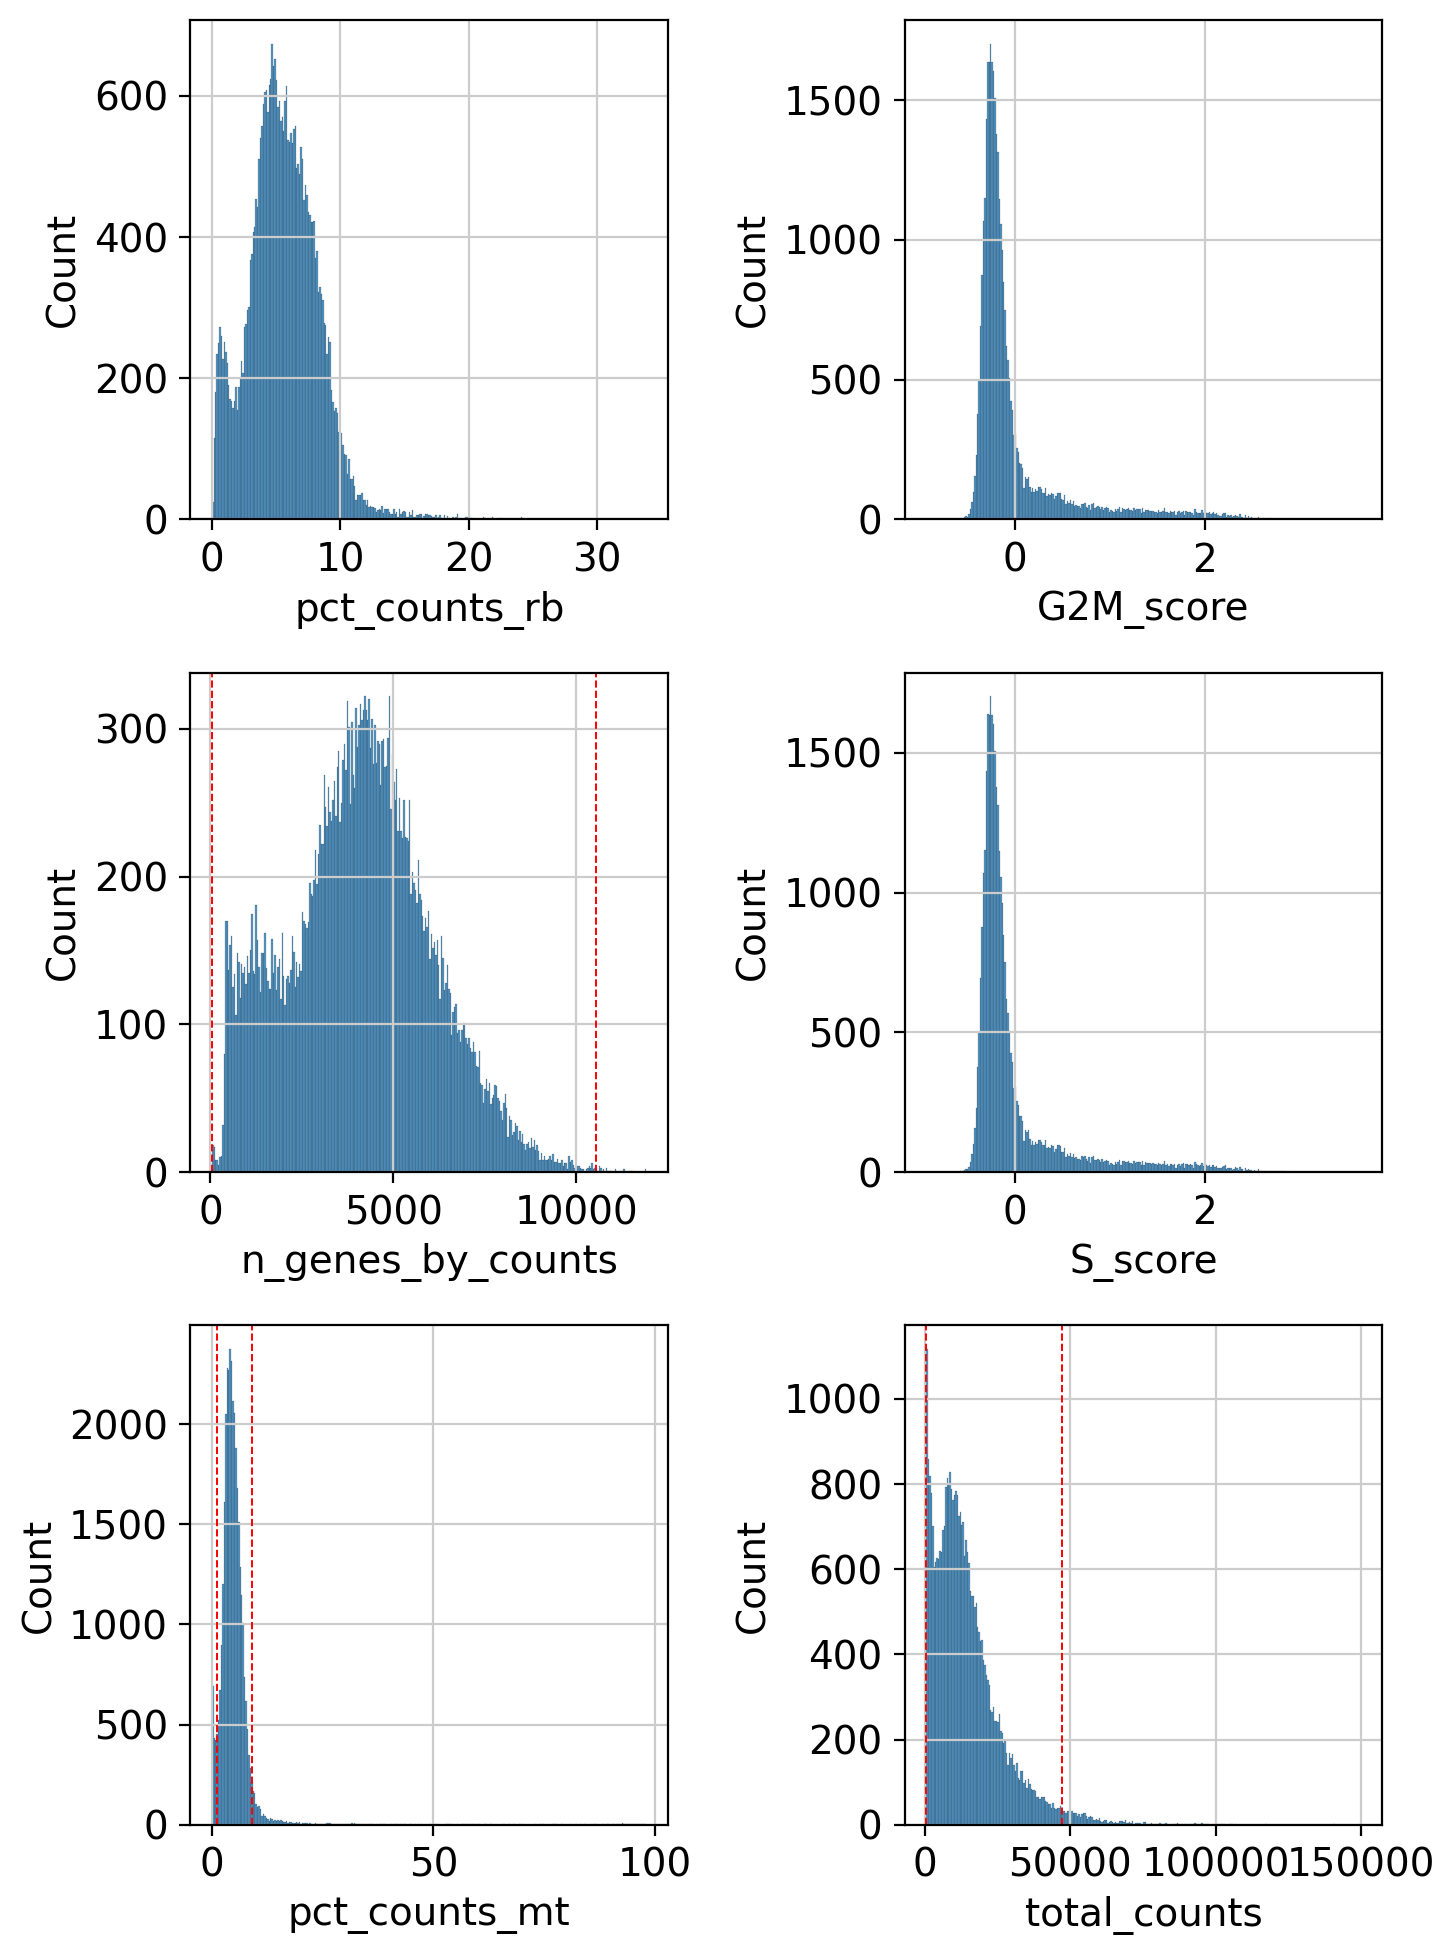

In [18]:
# Assuming 'df' is your DataFrame
df = adata.obs[keys]

# Determine the number of rows and columns for your subplot grid
n = len(df.columns)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create the subplots
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize + wspace * (nrows - 1) ),
)

plt.subplots_adjust(wspace=wspace, hspace=wspace)

# Flatten the axes
axs = axs.flatten()
outlier_dict = {}


# Plot a histogram on each subplot
for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, ax=axs[i], bins=300)

    if col in ["n_genes_by_counts", "total_counts"]:
        max_line = min(df[col].agg("mean")+ median_abs_deviation(df[col]) * NMADS,  df[col].agg("max")) 
        min_line = max(df[col].agg("mean") - median_abs_deviation(df[col]) * NMADS, df[col].agg("min"))
        axs[i].axvline(x=max_line, color='red', linestyle='--', linewidth = 0.7)
        axs[i].axvline(x=min_line, color='red', linestyle='--', linewidth = 0.7)

        outlier_dict[col] = (min_line, max_line)

    elif col in ["pct_counts_mt"]:
        max_line = min(df[col].agg("mean")+ median_abs_deviation(df[col]) * NMADS_MITO,  df[col].agg("max")) 
        min_line = max(df[col].agg("mean") - median_abs_deviation(df[col]) * NMADS_MITO, df[col].agg("min"))
        axs[i].axvline(x=max_line, color='red', linestyle='--', linewidth = 0.7)
        axs[i].axvline(x=min_line, color='red', linestyle='--', linewidth = 0.7)

        outlier_dict[col] = (min_line, max_line)

# Remove any unused subplots
if len(df.columns) < nrows*ncols:
    for i in range(len(df.columns), nrows*ncols):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## Filtering Thresholds

In [19]:
(pd.DataFrame(outlier_dict, index= ("Min", "Max")).T)

Min           Max
n_genes_by_counts   45.000000  10550.355534
pct_counts_mt        1.019326      9.071857
total_counts       500.000000  46976.495117

## Number of outliers based on provided criteria

In [20]:
#TODO: Fix
df_l = []
col_l = []
for key in prior_keys:
    try:
        df_l.append(pd.DataFrame(adata.obs[[f"{key}_outlier", "sample"]].value_counts()))
        col_l.append(f"{key}_outlier")
    except:
        pass

df_l.append(pd.DataFrame(adata.obs[[f"outlier", "sample"]].value_counts()))
col_l.append(f"aggregate outliers")

df = pd.concat(df_l, axis=1)
df.columns = [col_l]
(df.fillna(0))


n_genes_by_counts_outlier total_counts_outlier  \
      sample                                                   
False sample2                   10290.0                10286   
      sample1                    9197.0                 9133   
      sample3                    8215.0                 7800   
      sample4                    7343.0                 6751   
True  sample4                      22.0                  614   
      sample3                       7.0                  422   
      sample1                       0.0                   64   
      sample2                       0.0                    4   

              pct_counts_mt_outlier aggregate outliers  
      sample                                            
False sample2                  9251               9248  
      sample1                  8666               8602  
      sample3                  7531               7114  
      sample4                  6725               6123  
True  sample4                   640               1242  
      sample3                   691               1108  
      sample1                   531                595  
      sample2                  1039               1042

## Cell filtering based on outlier function

In [21]:
# Saving The object at the last step before subsseting
if path.exists(DIR_SAVE):
    adata.write_h5ad(path.join(DIR_SAVE, "raw_adata.h5ad"))
else:
    mkdir(DIR_SAVE)
    adata.write_h5ad(path.join(DIR_SAVE, "raw_adata.h5ad"))

# Cell Filtering based on threshold
adata = adata[(~adata.obs.outlier)].copy()

In [22]:
df1 = adata.obs.groupby("sample")[keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
pd.concat([df1, df2], axis =1)

pct_counts_rb        G2M_score        n_genes_by_counts          \
                 mean median      mean median              mean  median   
sample                                                                    
sample1         5.951  5.862    -0.005 -0.200          4128.167  4280.0   
sample3         5.448  5.258    -0.000 -0.207          4377.408  4643.5   
sample4         4.875  4.634     0.002 -0.189          4646.962  4966.0   
sample2         5.756  5.686    -0.028 -0.194          3402.320  3461.0   

        S_score        pct_counts_mt         total_counts          sample  
           mean median          mean median          mean   median   size  
sample                                                                     
sample1  -0.005 -0.200         4.452  4.351  13573.825195  12769.0   8602  
sample3  -0.000 -0.207         4.079  3.977  16685.796875  15659.0   7114  
sample4   0.002 -0.189         4.352  4.243  18362.970703  17684.0   6123  
sample2  -0.028 -0.194         4.913  4.880   9729.103516   8889.5   9248

In [23]:
keys

['pct_counts_rb',
 'G2M_score',
 'n_genes_by_counts',
 'S_score',
 'pct_counts_mt',
 'total_counts']

## Scatter plots of confounders after filtering

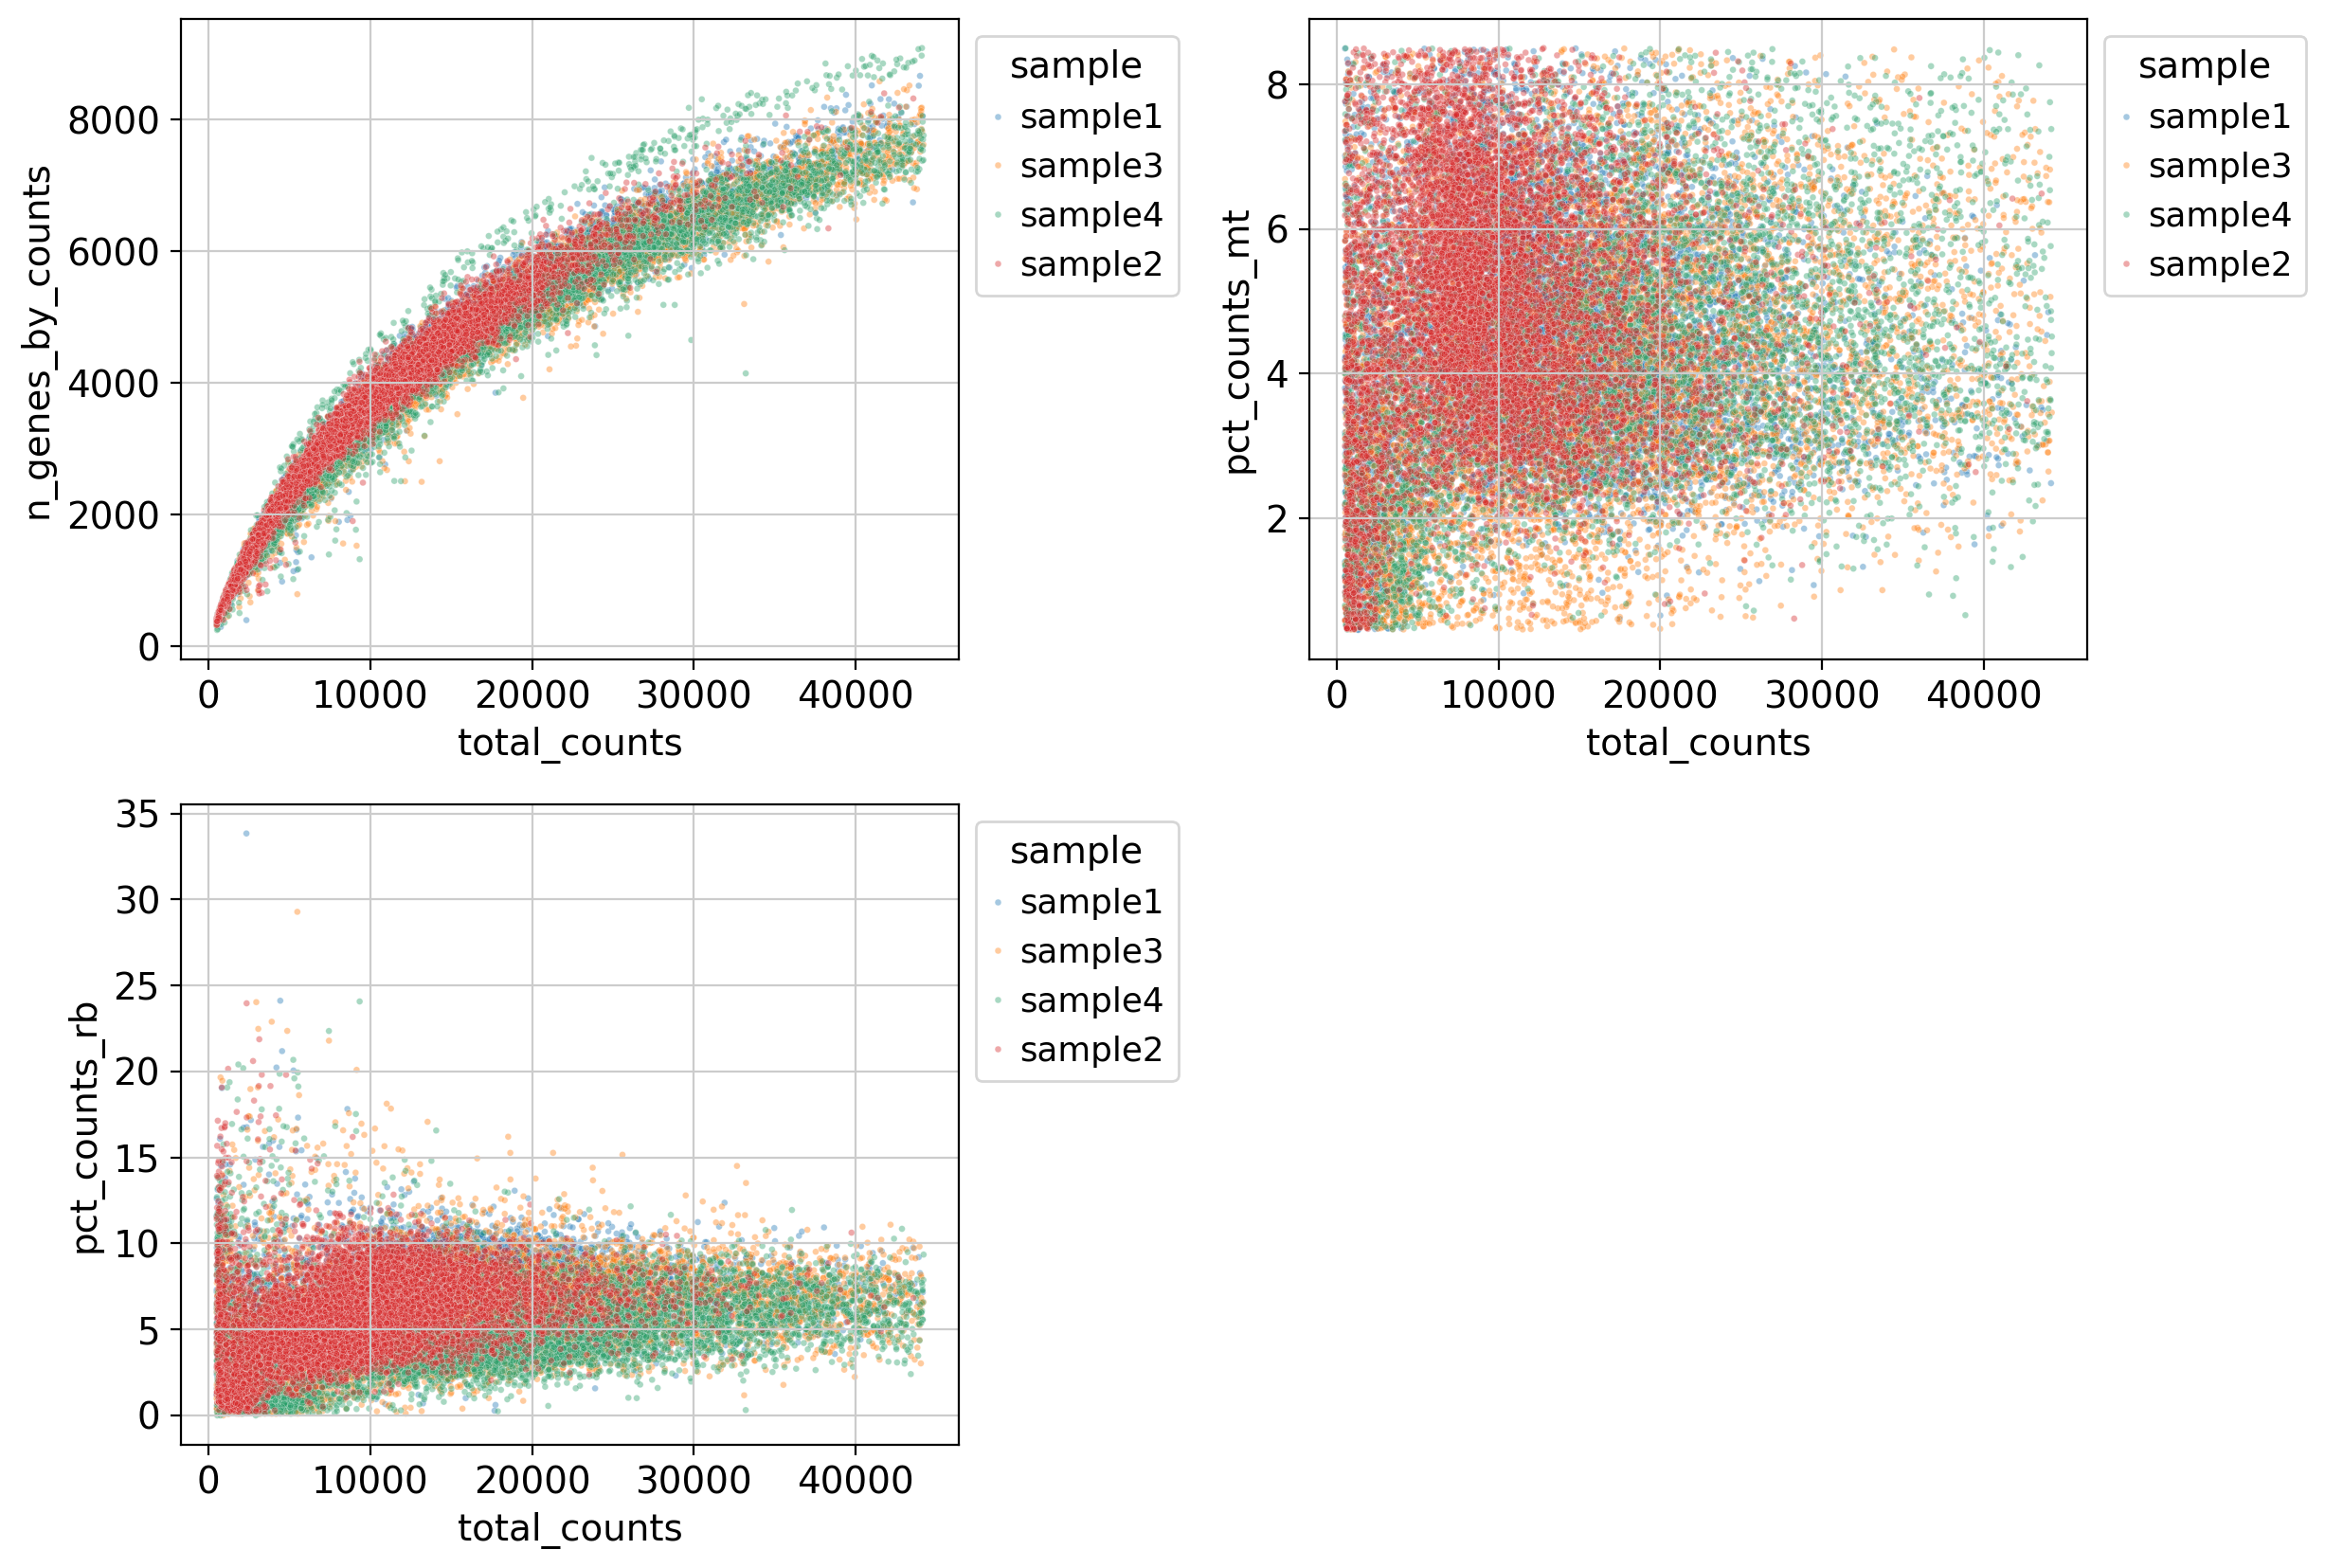

In [24]:
# Assuming 'df' is your DataFrame
df = adata.obs[keys+["sample"]]

# Determine the number of rows and columns for your subplot grid
n = len(df.columns)
ncols = 2
nrows = 2
figwidth= 5
figheight = 4

# Create the subplots
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figwidth + figwidth * wspace * (ncols - 1), nrows * figheight + wspace * (nrows - 1) ),
)

plt.subplots_adjust(wspace=wspace, hspace=wspace)

# Flatten the axes
axs = axs.flatten()

sns.scatterplot(df, x="total_counts", y="n_genes_by_counts", hue = "sample", alpha = 0.4, s = 6,  ax= axs[0])
sns.scatterplot(df, x="total_counts", y="pct_counts_mt", hue = "sample", alpha = 0.4, s = 6,  ax= axs[1])
sns.scatterplot(df, x="total_counts", y="pct_counts_rb", hue = "sample", alpha = 0.4, s = 6,  ax= axs[2])
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))

if FILTER_DOUBLETS:
    sns.scatterplot(df, x="total_counts", y="doublet_score", hue = "sample", alpha = 0.4, s = 6,  ax= axs[3])

[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]


plt.tight_layout()
plt.show()


## DecontX contamination

In [25]:

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":
    ax1 = pw.Brick(figsize=(6,6))
    ax2 = pw.Brick(figsize=(6,6))

    scatter = sns.scatterplot(pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis = 1), x = "DecontX_UMAP_1", y = "DecontX_UMAP_2", hue= "decontX_contamination" , s= 0.8, ax = ax1, palette="inferno")
    sns.move_legend(scatter, "center right", bbox_to_anchor=(1.1, 0.5), title=None, frameon=False)

    scatter = sns.scatterplot(pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis = 1), x = "DecontX_UMAP_1", y = "DecontX_UMAP_2", hue= "decontX_clusters" , s= 0.8, ax=ax2)
    sns.move_legend(scatter, "center right", bbox_to_anchor=(1.15, 0.5), title=None, frameon=False)

    ax12 = ax1+ax2
    display(ax12)

## Clustering after to cell filtering

In [26]:
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="leidenalg")
sc.tl.umap(adata)

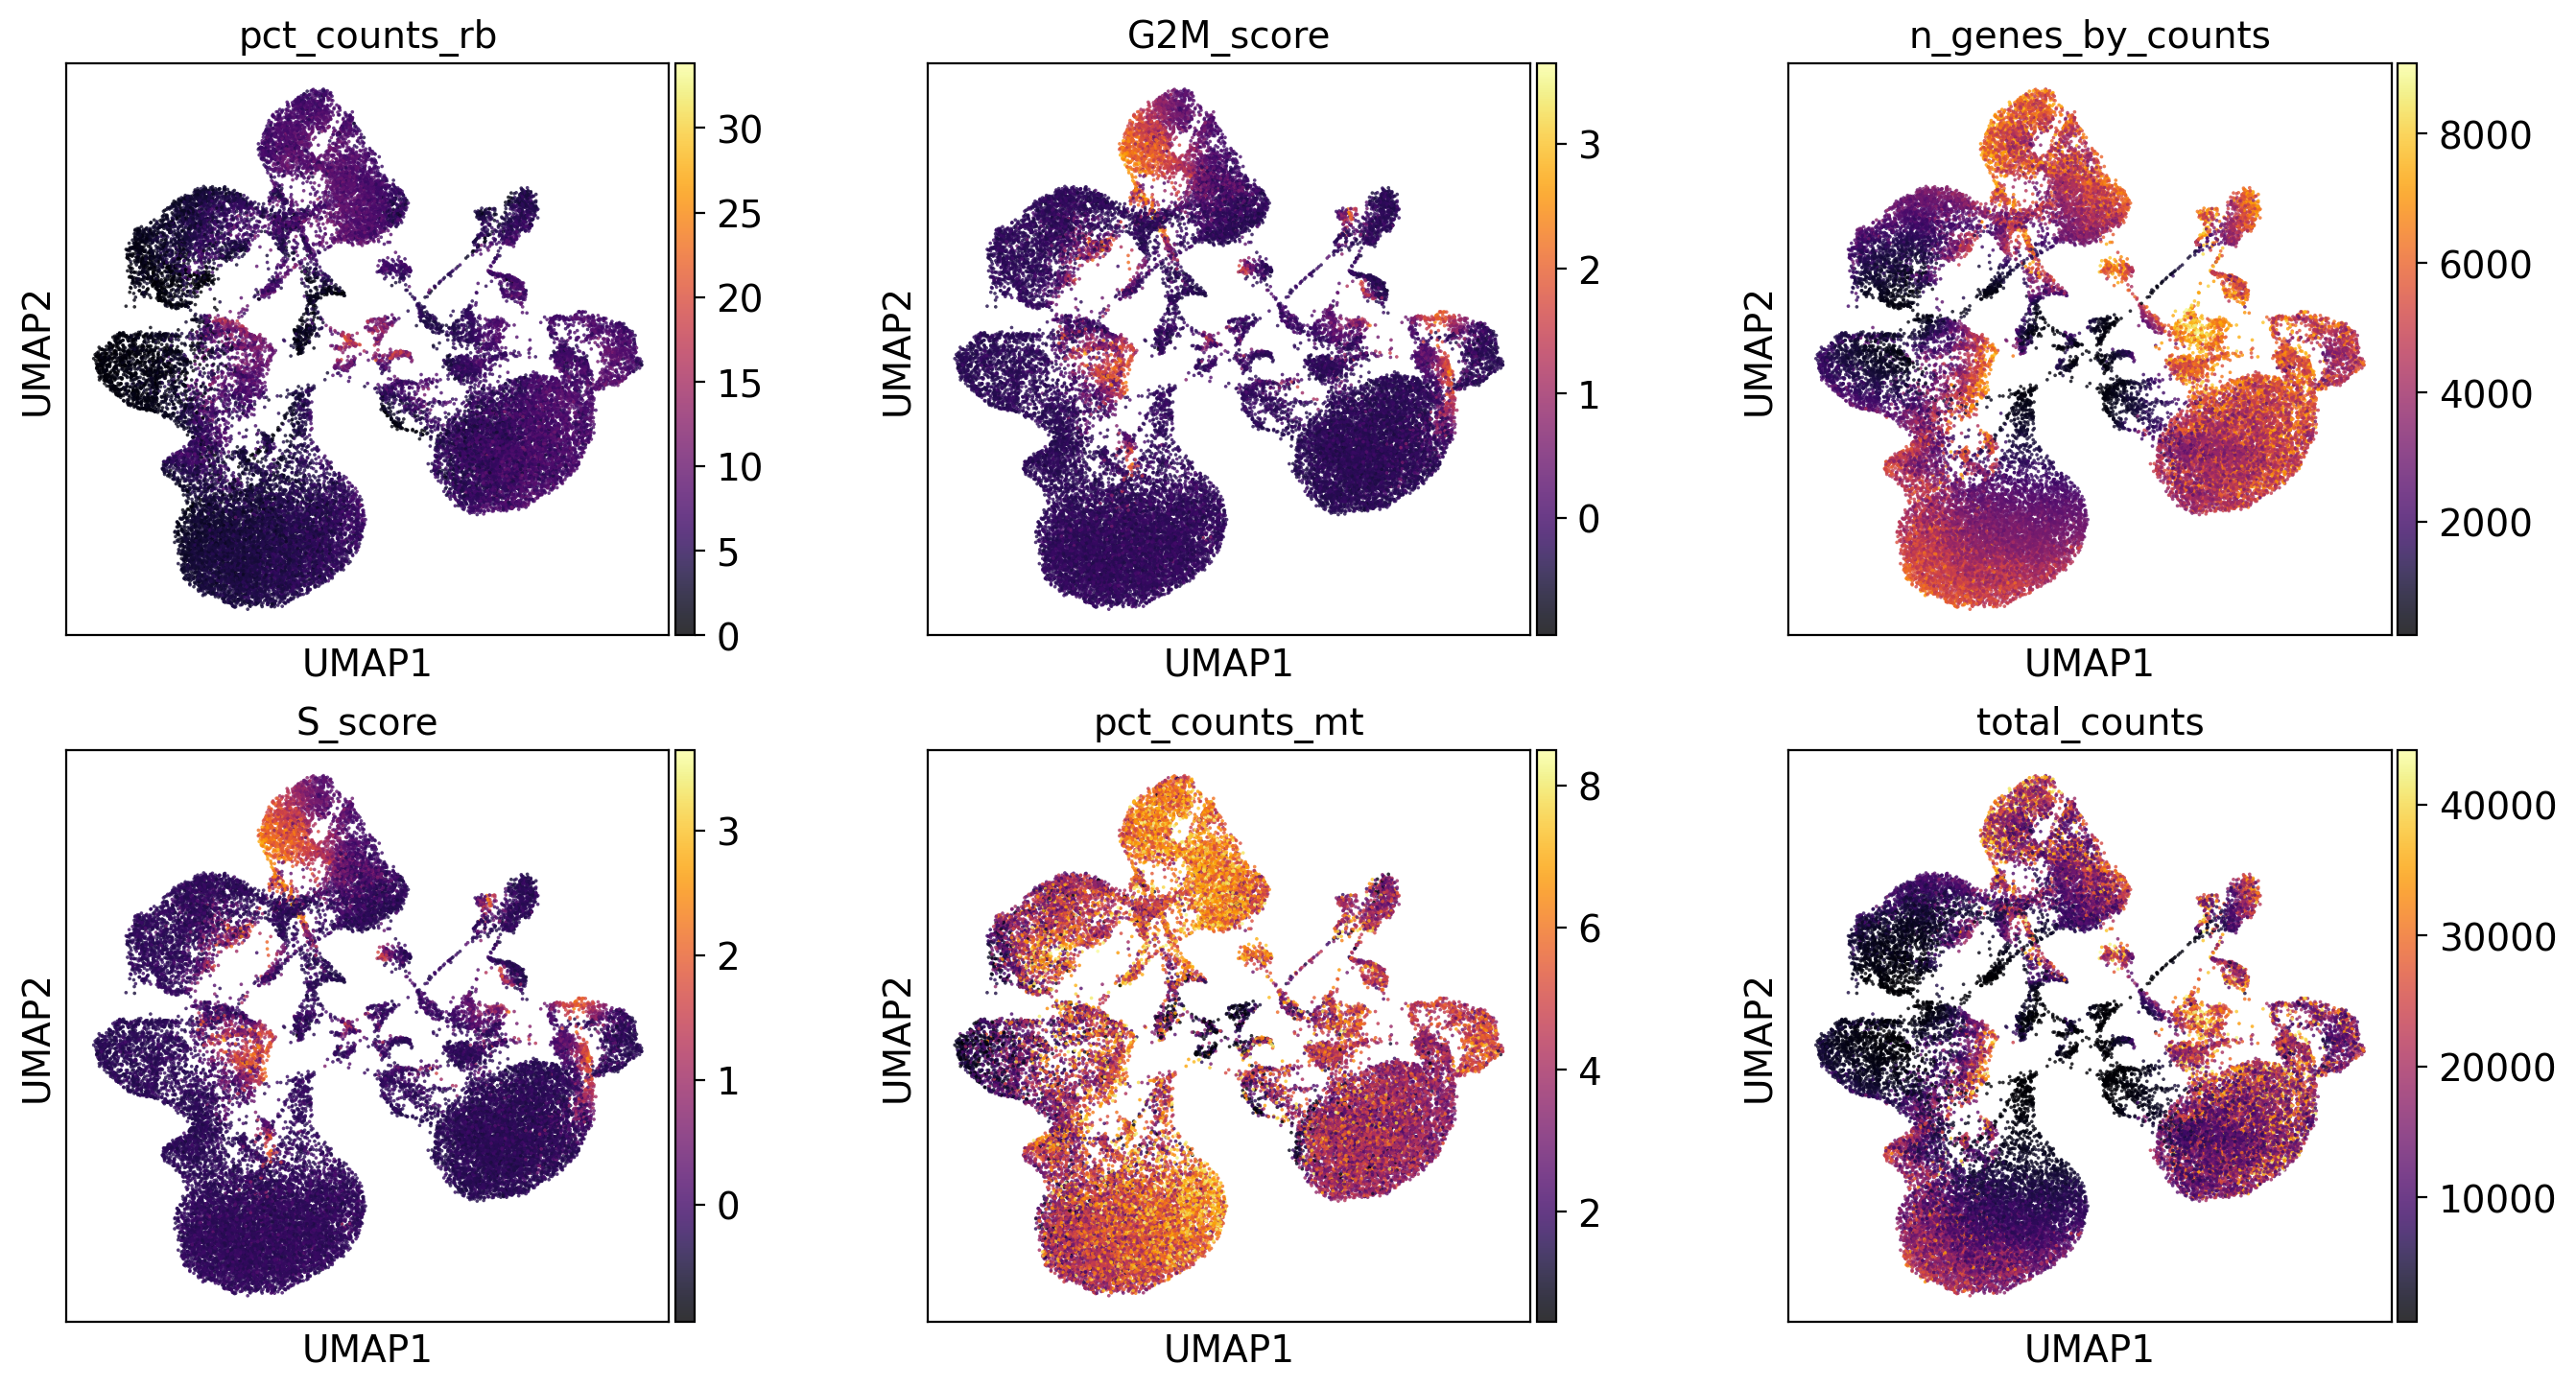

In [27]:
# -.-|m { input: false, output: true, input_fold: show}
# keys = ["sample", "total_counts", "n_genes_by_counts", "pct_counts_mt"]

# if FILTER_DOUBLETS:
#     keys = keys + ["predicted_doublet"]

# if CELL_CYCLE_SCORE:
#     keys = keys + ["phase"]

figs = sc.pl.umap(adata, size= 7, color= keys, show=False, ncols = 3, color_map="inferno", sort_order=False, alpha = 0.8,  hspace=0.2, wspace=0.3)

# Regression of Variables

In [28]:
# - [ ] Add error handling if the vars to regress is empty or contain non-keys
if REGRESS:
    sc.pp.regress_out(adata, keys= VARS_TO_REGRESS)

# Ambient RNA 

In [29]:
if CORRECT_AMBIENT_RNA:
    sns.violinplot(adata.obs, x = "decontX_clusters", y = "decontX_contamination")
    sns.stripplot(adata.obs, x = "decontX_clusters", y = "decontX_contamination", s = 1, c = "black")

In [30]:
## Save Result
if path.exists(DIR_SAVE):
    adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))
else:
    mkdir(DIR_SAVE)
    adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Session Information

In [31]:
session_info.show()